# Weather Prediction Neural Network Machine Learning Model: 

[Available on Google Colaboratory](https://colab.research.google.com/drive/1QrcjfdcahcBPU3FuKMhxMGozGRzMTA3H)

## About

In this project, I work with daily weather data for the city of Madrid from 1997 - 2015 to project future weather events.

The objective is to train a neural network that will predict various weather events including:

- Rain
- Snow
- Fog
- Thunderstorm
- Hail
- Tornado

## Submission

- Submitted as ipynb executed on Jupyter notebook.
- I use tensorflow, matplotlib, and pandas to build and train NN models.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Embedding
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Getting the data

The data is available at the given URL.  The following code will load the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/).

If you are unfamiliar with DataFrame API, you can easily pick it up from here: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

Very minimal knowledge of DataFrame is needed, as most of the code is provided in the notebook already.

In [0]:
url = 'https://github.com/ontariotechu-csci4050u/course-material-2019/' \
      'raw/master/data/weather_madrid_LEMD_1997_2015.csv.gz'
df = pd.read_csv(url).rename(columns={"CET": "date"}).set_index('date')
df.columns = [x.strip() for x in df.columns]

This is what the dataframe `df` looks like.  Note that it has a number of numerical attributes including _temperature_, _pressure_, _visibility_, etc.

In [4]:
df.head()

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
date,,,,,,,,,,,,,,,,,,,,,,
1997-1-1,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1997-1-2,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
1997-1-3,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
1997-1-4,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
1997-1-5,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


# Building the weather event columns

We construct _binary_ columns as indicators of the key weather events that occurred during the day.

The weather conditions are:

- Rain, Snow, Fog, Thunderstorm, Hail, Tornado
- and also _NoEvent_.

They are additional columns to the dataframe.

In [0]:
event_columns = ['Rain', 'Snow', 'Fog', 'Thunderstorm', 'Hail', 'Tornado', 'NoEvent']

In [0]:
for ev in event_columns:
  if ev == 'NoEvent':
    df[ev] = df['Events'].isna()
  else:
    df[ev] = df['Events'].str.contains(ev).fillna(False)

Here is the _augmented_ dataframe.  Scroll horizontally to make sure that `df` now contains the binary indicators of each weather event.

In [7]:
df.head()

# I filled in NaN fields so that loss function can be calculated as that requires no NaN fields
# --- This method is disabled as it yields less accurate results ---
#df['Events'] = df['Events'].fillna('NoEvent') # fill NaN values for events with 'NoEvent' so loss function can be calculated (requires no NaN fields)
#df = df.fillna(method = 'ffill') # fill other NaN values (ie. gust speed) on days that were not measured with previous day's values (more accurate than calculating as 0)
#df = df.fillna(method = 'bfill') # fill 0th index NaN values with the next day's values since ffill cannot fill 0th index values as there are no previous days

# fill NaN with 0
df = df.fillna(0)

print(df)

            Max TemperatureC  Mean TemperatureC  ...  Tornado  NoEvent
date                                             ...                  
1997-1-1                 7.0                4.0  ...    False     True
1997-1-2                 7.0                3.0  ...    False    False
1997-1-3                 5.0                3.0  ...    False    False
1997-1-4                 7.0                3.0  ...    False     True
1997-1-5                 2.0                0.0  ...    False    False
...                      ...                ...  ...      ...      ...
2015-12-27              14.0                7.0  ...    False    False
2015-12-28              15.0                8.0  ...    False    False
2015-12-29              11.0                8.0  ...    False    False
2015-12-30               9.0                8.0  ...    False     True
2015-12-31              12.0               10.0  ...    False    False

[6812 rows x 29 columns]


## Building the features

We identify the numeric columns as _observations_.  We will use these columns as input vectors to a neural network.

**Note**: Since large magnitude differences will cause serious numerical issues during gradient descent, we *always* use **normalized** vectors.  So for each numerical column, we compute the minimum and maximum values which are used to rescale the column to the range of :
`[0.0 .. 1.0]`

In [0]:
def get_normalized_features(df, columns):
  df2 = pd.DataFrame(index=df.index)
  for c in columns:
    series = df[c]
    max = series.max()
    min = series.min()
    df2[c] = (series - min) / (max - min)
  return df2

In [0]:
numeric_columns = [
       'Max TemperatureC',
       'Mean TemperatureC',
       'Min TemperatureC',
       'Dew PointC',
       'MeanDew PointC',
       'Min DewpointC',
       'Max Humidity',
       'Mean Humidity',
       'Min Humidity',
       'Max Sea Level PressurehPa',
       'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa',
       'Max VisibilityKm',
       'Mean VisibilityKm',
       'Min VisibilitykM',
       'Max Wind SpeedKm/h',
       'Mean Wind SpeedKm/h',
       'Max Gust SpeedKm/h',
       'Precipitationmm',
       'CloudCover',
       'WindDirDegrees']

The features are the normalized observations.  We can use them in learning a model to predict weather events.

In [10]:
features = get_normalized_features(df, numeric_columns)
features.head()

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees
date,,,,,,,,,,,,,,,,,,,,,
1997-1-1,0.170732,0.200000,0.315789,0.53125,0.580645,0.666667,1.00,0.95,0.76,0.301887,0.385965,0.513158,0.322581,0.290323,0.129032,0.071429,0.153846,0.000000,0.0,0.750,0.637119
1997-1-2,0.170732,0.171429,0.263158,0.56250,0.580645,0.611111,1.00,0.92,0.71,0.245283,0.298246,0.421053,0.322581,0.290323,0.129032,0.142857,0.205128,0.456311,0.0,0.625,0.398892
1997-1-3,0.121951,0.171429,0.315789,0.53125,0.516129,0.583333,1.00,0.85,0.70,0.207547,0.228070,0.407895,0.322581,0.322581,0.225806,0.148352,0.487179,0.000000,0.0,0.750,0.711911
1997-1-4,0.170732,0.171429,0.236842,0.31250,0.387097,0.500000,0.86,0.63,0.49,0.339623,0.421053,0.526316,0.322581,0.322581,0.322581,0.148352,0.487179,0.388350,0.0,0.250,0.789474
1997-1-5,0.048780,0.085714,0.236842,0.43750,0.483871,0.527778,1.00,0.95,0.86,0.339623,0.385965,0.526316,0.322581,0.161290,0.032258,0.076923,0.153846,0.000000,0.0,0.875,0.008310


In [11]:
features.shape

(6812, 21)

# Building Output

The targets are 0/1 columns for each of the 

In [12]:
targets = df[event_columns].applymap(lambda x: 1 if x else 0)
targets.head()

,Rain,Snow,Fog,Thunderstorm,Hail,Tornado,NoEvent
date,,,,,,,
1997-1-1,0,0,0,0,0,0,1
1997-1-2,1,0,0,0,0,0,0
1997-1-3,1,1,0,0,0,0,0
1997-1-4,0,0,0,0,0,0,1
1997-1-5,0,1,0,0,0,0,0


# Building the training and test data

We will split the data as follows:

- Training: 1997 - 2007
- Testing: 2007 - 2015

In [0]:
x_train = features.loc[:'2007-12-31']
x_test = features.loc['2008-1-1':]

y_train = targets.loc[x_train.index]
y_test = targets.loc[x_test.index]

In [14]:
x_train.shape, x_test.shape

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3890, 21)
(2922, 21)
(3890, 7)
(2922, 7)


In [15]:
y_test.head()

,Rain,Snow,Fog,Thunderstorm,Hail,Tornado,NoEvent
date,,,,,,,
2008-1-1,0,0,0,0,0,0,1
2008-1-2,1,0,0,0,0,0,0
2008-1-3,1,0,0,0,0,0,0
2008-1-4,0,0,0,0,0,0,1
2008-1-5,0,0,0,0,0,0,1


In [16]:
y_train.sum()


Rain             820
Snow              23
Fog              181
Thunderstorm     189
Hail               2
Tornado            1
NoEvent         2881
dtype: int64

# ✎ Build model(s)

You need to build a _Keras_ model that predicts the weather events.

The only restriction is that you must **NOT** use the dataframes `x_test`, `y_test` during training.

**Note**:

You can build one or more models (for example, one model for each and different weather event).

You need to design the architecture and the loss function.

In [17]:
# For a multi-label multi-class classification, sigmoid activation and binary crossentropy can be used.
# 4 dense layer MLP model with adam(0.001) as optimizer

model = Sequential([
  Input(shape=(21,)),
  Dense(7),
  Dense(7),
  Dense(7),
  Dense(7, activation='sigmoid')
])
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 154       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


# ✎ Train the model(s)

You must:

- Select an appropriate optimizer and learning rate.
- Plot the loss over the epochs of training.
- Plot the training accuracy over the epochs.

**Challenge**

It's extremely difficult to get good training on _rare_ events.  Note that there is only **ONE** Tornado and **TWO** Hail events in the training data.

An effective way is to duplicate the rare events in the training data, and use _shuffle=True_ in the training (model.fit) so that the network sees approximately equal number of occurrances of different weather events.

Train on 4078 samples, validate on 454 samples
Epoch 1/10
4078/4078 [==============================] - 4s 953us/sample - loss: 0.2603 - acc: 0.8991 - val_loss: 0.9691 - val_acc: 0.6114
Epoch 2/10
4078/4078 [==============================] - 2s 575us/sample - loss: 0.1730 - acc: 0.9337 - val_loss: 0.7889 - val_acc: 0.7074
Epoch 3/10
4078/4078 [==============================] - 2s 575us/sample - loss: 0.1564 - acc: 0.9397 - val_loss: 0.6531 - val_acc: 0.7291
Epoch 4/10
4078/4078 [==============================] - 2s 569us/sample - loss: 0.1510 - acc: 0.9420 - val_loss: 0.6703 - val_acc: 0.7244
Epoch 5/10
4078/4078 [==============================] - 2s 572us/sample - loss: 0.1468 - acc: 0.9422 - val_loss: 0.6696 - val_acc: 0.7420
Epoch 6/10
4078/4078 [==============================] - 2s 563us/sample - loss: 0.1435 - acc: 0.9427 - val_loss: 0.6903 - val_acc: 0.7278
Epoch 7/10
4078/4078 [==============================] - 2s 589us/sample - loss: 0.1401 - acc: 0.9440 - val_loss: 0.5419 - val

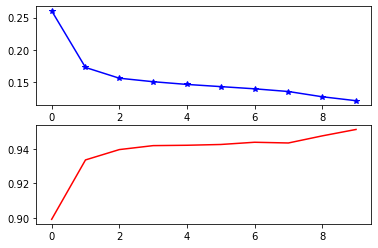

In [18]:
# Oversampling technique (duplicating under-represented rare events)
y_train_np = y_train.to_numpy()
x_train_np = x_train.to_numpy()
oversampled_y_train = y_train_np
oversampled_x_train = x_train_np

snow_events_indices = []
fog_events_indices = []
thunderstorm_events_indices = []
hail_events_indices = []
tornado_events_indices = []

# Get rare events indices to duplicate
# -------------------------------------------
for i in range(1,3890):
    if y_train_np[i][1] == 1: # Snow
      snow_events_indices.append(i)
    if y_train_np[i][2] == 1: # Fog
      fog_events_indices.append(i)
    if y_train_np[i][3] == 1: # Thunderstorm
      thunderstorm_events_indices.append(i) 
    if y_train_np[i][4] == 1: # Hail
      hail_events_indices.append(i)
    if y_train_np[i][5] == 1: # Tornado
      tornado_events_indices.append(i)
# -------------------------------------------

# Oversampling: Duplicate each [SNOW] event 3 times
# ---------------------------------------------------------
repetitions = 3

for i in range(1,len(snow_events_indices)):
  y_duplicate = np.repeat([oversampled_y_train[snow_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_y_train = np.vstack([oversampled_y_train, y_duplicate])
  x_duplicate = np.repeat([oversampled_x_train[snow_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_x_train = np.vstack([oversampled_x_train, x_duplicate])
# ---------------------------------------------------------

# Oversampling: Duplicate each [FOG] events 1 time
# ---------------------------------------------------------
repetitions = 1
total_sample_pool = 1.0

for i in range(1,int(len(fog_events_indices)*total_sample_pool)):
  y_duplicate = np.repeat([oversampled_y_train[fog_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_y_train = np.vstack([oversampled_y_train, y_duplicate])
  x_duplicate = np.repeat([oversampled_x_train[fog_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_x_train = np.vstack([oversampled_x_train, x_duplicate])
# ---------------------------------------------------------

# Oversampling: Duplicate each [THUNDERSTORM] events 2 times
# ---------------------------------------------------------
repetitions = 2
total_sample_pool = 1.0

for i in range(1,int(len(thunderstorm_events_indices)*total_sample_pool)):
  y_duplicate = np.repeat([oversampled_y_train[thunderstorm_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_y_train = np.vstack([oversampled_y_train, y_duplicate])
  x_duplicate = np.repeat([oversampled_x_train[thunderstorm_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_x_train = np.vstack([oversampled_x_train, x_duplicate])
# ---------------------------------------------------------

# Oversampling: Duplicate each [HAIL] event 20 times
# ---------------------------------------------------------
repetitions = 20

for i in range(1,len(hail_events_indices)):
  y_duplicate = np.repeat([oversampled_y_train[hail_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_y_train = np.vstack([oversampled_y_train, y_duplicate])
  x_duplicate = np.repeat([oversampled_x_train[hail_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_x_train = np.vstack([oversampled_x_train, x_duplicate])
# ---------------------------------------------------------

# Oversampling: Duplicate each [TORNADO] event 20 times
# ---------------------------------------------------------
repetitions = 20

for i in range(1,len(tornado_events_indices)):
  y_duplicate = np.repeat([oversampled_y_train[tornado_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_y_train = np.vstack([oversampled_y_train, y_duplicate])
  x_duplicate = np.repeat([oversampled_x_train[tornado_events_indices[i]]],repeats=repetitions ,axis=0)
  oversampled_x_train = np.vstack([oversampled_x_train, x_duplicate])
# ---------------------------------------------------------



# Train oversampled model
history = model.fit(oversampled_x_train, oversampled_y_train, epochs=10, batch_size=4, shuffle=True, validation_split=0.1).history

# Train normal model
#history2 = model.fit(x_train.to_numpy(), y_train.to_numpy(), epochs=10, batch_size=4, validation_split=0.1).history

model.summary()

# Oversampled plot
print("Loss")
pyplot.subplot(2,1,1)
pyplot.plot(history['loss'], '-*', color='blue');
print("Acc")
pyplot.subplot(2,1,2)
pyplot.plot(history['acc'], '-', color='red');

# ✎ Evaluation

Evaluate the model using the test data.

- You must plot the test accurarcy with respect to **each** event type.

- For which weather event is your model actually useful?


2922/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

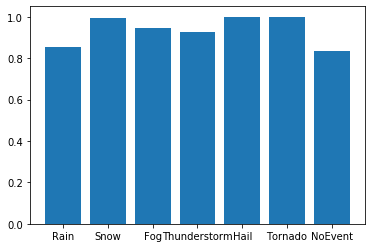


Prediction (2007 - 2015)
Rain		772
Snow		22
Fog		209
Thunderstorm	184
Hail		0
Tornado		0
NoEvent		1968

Actual (2007 - 2015)
Rain             680
Snow              30
Fog              128
Thunderstorm     113
Hail               6
Tornado            0
NoEvent         2133
dtype: int64


In [19]:
#np.set_printoptions(threshold=np.inf)

overall_accuracy = model.evaluate(x_test.to_numpy(), y_test.to_numpy())
overall_accuracy = overall_accuracy[1]
print("\nOverall Accuracy:")
print(overall_accuracy)

# z = np.argmax(model.predict(x_test.to_numpy()), axis=1)

# Count weather event occurences based on a threshold 0.5 weighted probability outputted through our 'sigmoid' loss function 
# Instead of using argmax, this allows for potentially more than 1 weather event in a given day (multi classification)
## -------------------------------------------------------------------------------------------------------------------------

# Prediction event counter, prediction model 
predictedEvents = [0] * 7
predictY = model.predict(x_test.to_numpy())

# Actual events, to test against for accuracy calculation
y_test_np = y_test.to_numpy()
TP_predictions = [0] * 7 # True Positive (Predict yes, it was yes)
TN_predictions = [0] * 7 # True Negative (Predict no, it was no)
FP_predictions = [0] * 7 # False Positive (Predict yes, it was no)
FN_predictions = [0] * 7 # False Negative (Predict no, it was yes)

# Count predictions
for i in range(2922):
  for j in range(7):
    if predictY[i][j] >= 0.5: # Above our assumed threshold, we predict it occurs
      predictedEvents[j] += 1
      if y_test_np[i][j] == 1: # If we predict yes and actual was yes
        TP_predictions[j] +=1
      else: # Otherwise, we predict yes but it was actually no
        FP_predictions[j] +=1
    if predictY[i][j] < 0.5: # If value is below our threshold, we predict it does not occur
      if y_test_np[i][j] == 0:
        TN_predictions[j] +=1 # We are right, it does not occur
      else: # Otherwise, we are wrong
        FN_predictions[j] +=1  

# Print predictions
print("\n# of True Positive Predictions (for each event type)")
print(TP_predictions)

print("\n# of True Negative Predictions")
print(TN_predictions)

print("\n# of False Positive Predictions")
print(FP_predictions)

print("\n# of False Negative Predictions")
print(FN_predictions)

# prediction accuracy for each event type
prediction_accuracy = [0] * 7 

# The accuracy formula is: True Positive + True Negative / Total
# Total = TP + TN + FP + FN
# Thus, TP + TN / (TP + TN + FP + FN), is the accuracy for each event type

# Calculate accuracy according to formula
for i in range(7):
  prediction_accuracy[i] = ((TP_predictions[i] + TN_predictions[i]) / (TP_predictions[i] + TN_predictions[i] + FP_predictions[i] + FN_predictions[i]))

# Print accuracy per event type
# Accuracy, calculated with True Positive + True Negative / Total, yields 85-100% accuracy overall for each event type
print("\nAccuracy per event type:")
print(prediction_accuracy)

# Plot accuracies with respect to each event type
y_pos = np.arange(len(event_columns))
pyplot.bar(y_pos, prediction_accuracy);
pyplot.xticks(y_pos, event_columns)
pyplot.show()

## Show prediction
## ----------------------------
print("\nPrediction (2007 - 2015)")
print("Rain\t\t" + str(predictedEvents[0]))
print("Snow\t\t" + str(predictedEvents[1]))
print("Fog\t\t" + str(predictedEvents[2]))
print("Thunderstorm\t" + str(predictedEvents[3]))
print("Hail\t\t" + str(predictedEvents[4]))
print("Tornado\t\t" + str(predictedEvents[5]))
print("NoEvent\t\t" + str(predictedEvents[6]))
## ----------------------------

## Show Actual
## ----------------------------
print("\nActual (2007 - 2015)")
print(y_test.sum())

# --------------------
# ----- Analysis -----
# --------------------
# For which weather event is your model actually useful?
# ------------------------------------------------------
# 
# This model, given weather attributes, is most useful for predicting common events.
# This includes 'NoEvent' and 'Rain'.
# Rare events are more difficult to predict, even with duplicated rare events.
# This is due to the probability of common events being almost always vastly greater.
# To partially remedy this, I allow any event with a threshold greater than 0.5 weighted 
# probability from the 'sigmoid' function to count as an occurrence.
# All rare events are also duplicated.


